In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [2]:
# evaluation metrics
def rmse(
    y_true: np.ndarray,
    y_pred: np.ndarray,
) -> float:
    """Calculate Root Mean Squared Error."""
    return np.sqrt(np.mean((y_true - y_pred) ** 2))


In [3]:
# Load datasets
usecols = [
    "price",
    "year",
    "manufacturer",
    "condition",
    "cylinders",
    "fuel",
    "odometer",
    "transmission",
    "drive",
    "type",
    "paint_color",
]

train_df = pd.read_csv("../dataset/projectA_vehicle_train.csv", usecols=usecols)
val_df = pd.read_csv("../dataset/projectA_vehicle_val.csv", usecols=usecols)
test_df = pd.read_csv("../dataset/projectA_vehicle_test.csv", usecols=usecols)

## Preprocessing

In [4]:
numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
categorical_columns = []
features = train_df.columns.values.tolist()
for col in features:
    if train_df[col].dtype in numerics:
        continue
    categorical_columns.append(col)

# Preprocess datasets
train_df_preprocessed = train_df.copy()
val_df_preprocessed = val_df.copy()
test_df_preprocessed = test_df.copy()

# Encoding categorical features
for col in categorical_columns:
    if col in train_df.columns:
        le = LabelEncoder()
        le.fit(list(train_df[col].astype(str).values))
        train_df_preprocessed[col] = le.transform(
            list(train_df[col].astype(str).values)
        )
        val_df_preprocessed[col] = le.transform(list(val_df[col].astype(str).values))
        test_df_preprocessed[col] = le.transform(list(test_df[col].astype(str).values))


In [5]:
# split training set to validation set
train_set = lgb.Dataset(
    train_df_preprocessed.drop(columns="price").to_numpy(),
    train_df_preprocessed["price"].to_numpy(),
)
valid_set = lgb.Dataset(
    val_df_preprocessed.drop(columns="price").to_numpy(),
    val_df_preprocessed["price"].to_numpy(),
)

test_set = lgb.Dataset(
    test_df_preprocessed.drop(columns="price").to_numpy(),
    test_df_preprocessed["price"].to_numpy(),
)

## train a model

In [6]:
params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "num_leaves": 31,
    "learning_rate": 0.01,
    "max_depth": -1,
    "subsample": 0.8,
    "bagging_fraction": 1,
    "max_bin": 5000,
    "bagging_freq": 20,
    "colsample_bytree": 0.6,
    "metric": "rmse",
    "min_split_gain": 0.5,
    "min_child_weight": 1,
    "min_child_samples": 10,
    "scale_pos_weight": 1,
    "zero_as_missing": False,
    "seed": 0,
}

model = lgb.train(
    params,
    train_set=train_set,
    num_boost_round=10000,
    # early_stopping_rounds=8000,
    # verbose_eval=500,
    valid_sets=valid_set,
)

[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1942
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 10
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Start training from score 155620.302875


In [7]:
# prediction accuracy

# train
y_pred = model.predict(train_df_preprocessed.drop(columns="price").values)
rmse_score = rmse(train_df["price"].values, y_pred)
print(f"RMSE on training set: {rmse_score:,.4f}")

# validation
y_pred = model.predict(val_df_preprocessed.drop(columns="price").values)
rmse_score = rmse(val_df["price"].values, y_pred)
print(f"RMSE on validation set: {rmse_score:,.4f}")

# test
y_pred = model.predict(test_df_preprocessed.drop(columns="price").values)
rmse_score = rmse(test_df["price"].values, y_pred)
print(f"RMSE on test set: {rmse_score:,.4f}")

RMSE on training set: 552,565.1586
RMSE on validation set: 5,359,584.0623
RMSE on test set: 7,654,816.5886


## train a model with filtered data

In [8]:
# remove outlier samples
train_df_filtered = train_df_preprocessed[train_df_preprocessed["price"] > 1000]
train_df_filtered = train_df_filtered[train_df_filtered["price"] < 40000]

# split training set to validation set
train_set_filtered = lgb.Dataset(
    train_df_filtered.drop(columns="price").to_numpy(),
    train_df_filtered["price"].to_numpy(),
)

valid_set = lgb.Dataset(
    val_df_preprocessed.drop(columns="price").to_numpy(),
    val_df_preprocessed["price"].to_numpy(),
)

test_set = lgb.Dataset(
    test_df_preprocessed.drop(columns="price").to_numpy(),
    test_df_preprocessed["price"].to_numpy(),
)

In [11]:
# ベースラインモデルの訓練
baseline_params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "rmse",
    "num_leaves": 31,
    "learning_rate": 0.1,
    "seed": 42,
    "verbose": -1,
}


model = lgb.train(
    baseline_params,
    train_set=train_set_filtered,
    num_boost_round=10000,
    # early_stopping_rounds=8000,
    # verbose_eval=500,
    valid_sets=valid_set,
)

In [22]:
# train
y_pred = model.predict(train_df_filtered.drop(columns="price").values)
rmse_score = rmse(train_df_filtered["price"].values, y_pred)
print(f"RMSE on training set: {rmse_score:,.4f}")

# validation
y_pred = model.predict(val_df_preprocessed.drop(columns="price").values)
rmse_score = rmse(val_df_preprocessed["price"].values, y_pred)
print(f"RMSE on validation set: {rmse_score:,.4f}")

# test
y_pred = model.predict(test_df_preprocessed.drop(columns="price").values)
rmse_score = rmse(test_df_preprocessed["price"].values, y_pred)
print(f"RMSE on test set: {rmse_score:,.4f}")

RMSE on training set: 116.5406
RMSE on validation set: 9,346.8427
RMSE on test set: 7,588.1041


## 特徴量重要度

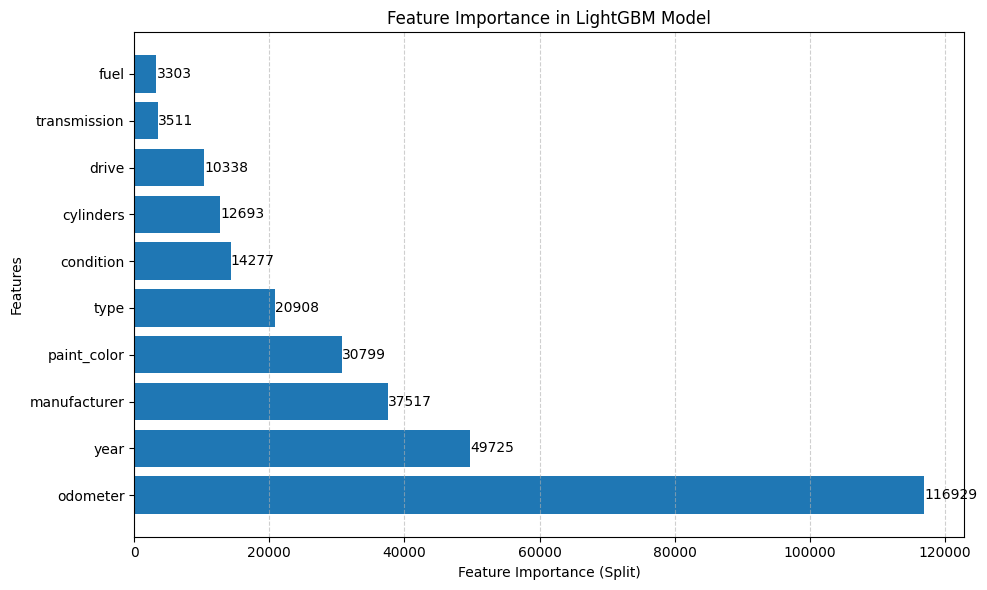

Feature Importance Ranking:
odometer: 116929
year: 49725
manufacturer: 37517
paint_color: 30799
type: 20908
condition: 14277
cylinders: 12693
drive: 10338
transmission: 3511
fuel: 3303


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from the model
feature_importances = model.feature_importance(importance_type="split")
feature_names = train_df.drop(columns="price").columns.tolist()

# Create a DataFrame for easier handling
importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importances}
)

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values("Importance", ascending=False)

# Create the plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Feature Importance (Split)")
plt.ylabel("Features")
plt.title("Feature Importance in LightGBM Model")
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Add values on bars
for i, v in enumerate(importance_df["Importance"]):
    plt.text(v + 5, i, str(v), va="center")

plt.tight_layout()
plt.show()

# Print the importance values
print("Feature Importance Ranking:")
for i, row in importance_df.iterrows():
    print(f"{row['Feature']}: {row['Importance']}")

## 予測結果の分析

In [15]:
# validation
y_pred = model.predict(val_df_preprocessed.drop(columns="price").values)
val_df["predicted_price"] = y_pred

val_df

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,predicted_price
0,5999,2013.0,ford,excellent,4 cylinders,gas,134146.0,automatic,fwd,sedan,black,8371.133789
1,3175,2008.0,saturn,excellent,6 cylinders,gas,118107.0,automatic,fwd,sedan,red,4239.095898
2,34990,2018.0,jeep,good,6 cylinders,gas,37509.0,other,4wd,other,black,34947.149917
3,20000,2019.0,ford,good,6 cylinders,gas,20163.0,automatic,rwd,truck,white,34039.268677
4,21990,2011.0,ford,excellent,6 cylinders,gas,1234.0,automatic,4wd,truck,white,16202.338509
...,...,...,...,...,...,...,...,...,...,...,...,...
995,4000,2008.0,mazda,good,4 cylinders,gas,166399.0,automatic,fwd,sedan,black,3807.433413
996,7495,2007.0,toyota,like new,6 cylinders,gas,208380.0,automatic,4wd,SUV,blue,10476.567690
997,30000,2017.0,lexus,like new,4 cylinders,gas,27000.0,automatic,fwd,SUV,white,23627.593493
998,15900,2011.0,infiniti,good,8 cylinders,gas,129500.0,automatic,4wd,SUV,white,17386.379647


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# 予測精度の分析
y_pred = model.predict(val_df_preprocessed.drop(columns="price").values)
val_df_analysis = val_df.copy()
val_df_analysis["predicted_price"] = y_pred

# 残差（実際値 - 予測値）を計算
val_df_analysis["residual"] = (
    val_df_analysis["price"] - val_df_analysis["predicted_price"]
)
val_df_analysis["abs_residual"] = abs(val_df_analysis["residual"])
val_df_analysis["relative_error"] = (
    abs(val_df_analysis["residual"]) / val_df_analysis["price"]
)

# 予測精度が悪いデータの閾値を設定（上位10%）
error_threshold = val_df_analysis["abs_residual"].quantile(0.9)
print(f"絶対残差の90%点: ${error_threshold:,.2f}")

# 予測精度が悪いデータを抽出
poor_predictions = val_df_analysis[val_df_analysis["abs_residual"] > error_threshold]
good_predictions = val_df_analysis[val_df_analysis["abs_residual"] <= error_threshold]

print(
    f"予測精度が悪いデータ数: {len(poor_predictions)} / {len(val_df_analysis)} ({len(poor_predictions) / len(val_df_analysis) * 100:.1f}%)"
)

val_df_analysis.head()

絶対残差の90%点: $9,045.54
予測精度が悪いデータ数: 100 / 1000 (10.0%)


,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,predicted_price,residual,abs_residual,relative_error
0,5999,2013.0,ford,excellent,4 cylinders,gas,134146.0,automatic,fwd,sedan,black,8371.133789,-2372.133789,2372.133789,0.395422
1,3175,2008.0,saturn,excellent,6 cylinders,gas,118107.0,automatic,fwd,sedan,red,4239.095898,-1064.095898,1064.095898,0.335148
2,34990,2018.0,jeep,good,6 cylinders,gas,37509.0,other,4wd,other,black,34947.149917,42.850083,42.850083,0.001225
3,20000,2019.0,ford,good,6 cylinders,gas,20163.0,automatic,rwd,truck,white,34039.268677,-14039.268677,14039.268677,0.701963
4,21990,2011.0,ford,excellent,6 cylinders,gas,1234.0,automatic,4wd,truck,white,16202.338509,5787.661491,5787.661491,0.263195


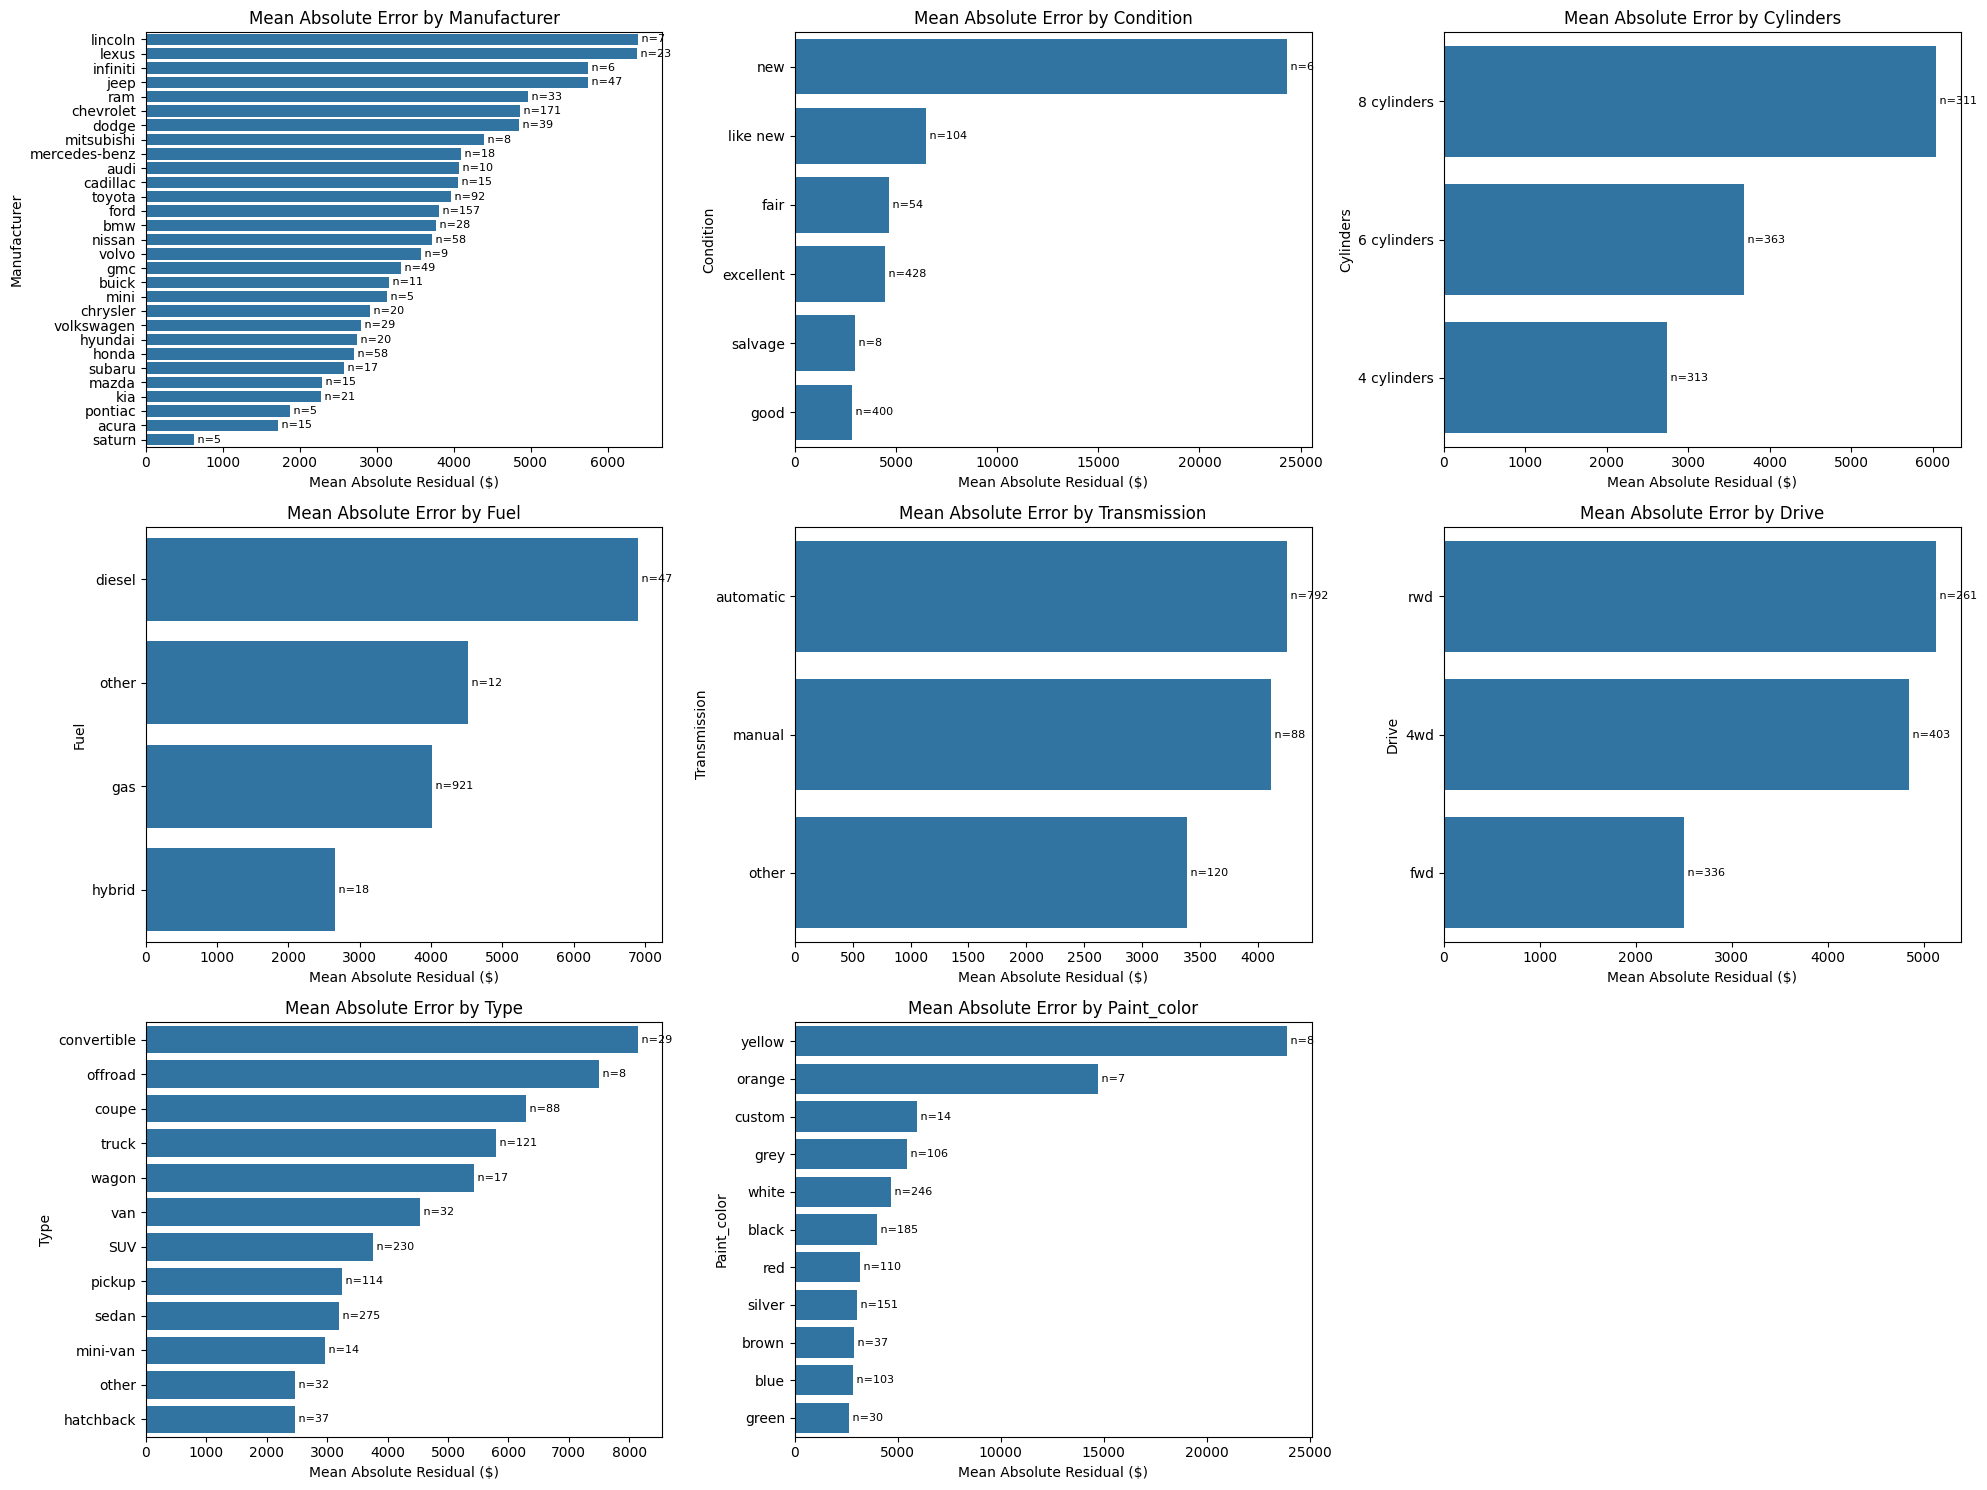

In [17]:
# カテゴリカル変数別の予測精度分析
categorical_vars = [
    "manufacturer",
    "condition",
    "cylinders",
    "fuel",
    "transmission",
    "drive",
    "type",
    "paint_color",
]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
axes = axes.flatten()

for i, var in enumerate(categorical_vars):
    ax = axes[i]

    # カテゴリ別の平均絶対残差を計算
    category_error = (
        val_df_analysis.groupby(var)["abs_residual"]
        .agg(["mean", "count"])
        .reset_index()
    )
    category_error = category_error[
        category_error["count"] >= 5
    ]  # サンプル数が5以上のカテゴリのみ
    category_error = category_error.sort_values("mean", ascending=False)

    # 棒グラフで表示
    sns.barplot(data=category_error, x="mean", y=var, ax=ax, orient="h")
    ax.set_title(f"Mean Absolute Error by {var.capitalize()}", fontsize=12)
    ax.set_xlabel("Mean Absolute Residual ($)", fontsize=10)
    ax.set_ylabel(var.capitalize(), fontsize=10)

    # サンプル数も表示
    for j, (idx, row) in enumerate(category_error.iterrows()):
        ax.text(row["mean"], j, f" n={row['count']}", va="center", fontsize=8)

# 残りのサブプロットを非表示
for j in range(len(categorical_vars), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

/var/folders/t_/dwjjhrlx797gmhhc3w21v3y40000gn/T/ipykernel_3205/3801231660.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_bin_error = val_df_analysis.groupby("price_bin")["abs_residual"].mean()
/var/folders/t_/dwjjhrlx797gmhhc3w21v3y40000gn/T/ipykernel_3205/3801231660.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  odometer_bin_error = val_df_analysis.groupby("odometer_bin")["abs_residual"].mean()


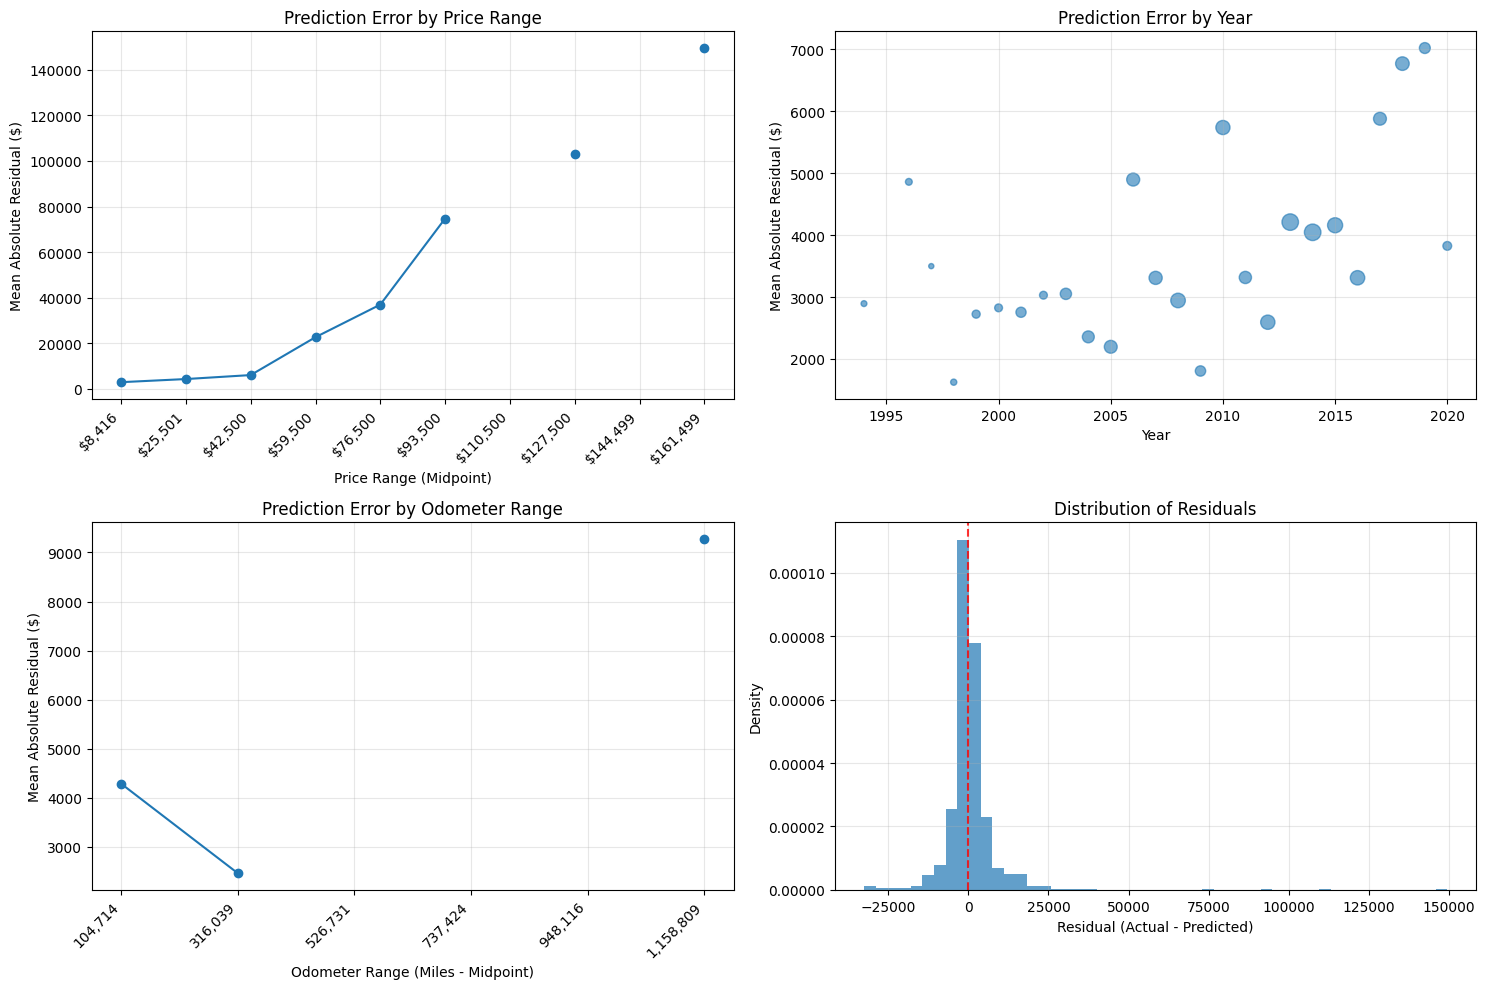

In [18]:
# 数値変数と予測精度の関係分析
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()

# 価格帯別の予測精度
ax = axes[0]
# 価格帯を10分割し、具体的な金額範囲でラベルを作成
price_bins = pd.cut(val_df_analysis["price"], bins=10)
val_df_analysis["price_bin"] = price_bins
price_bin_error = val_df_analysis.groupby("price_bin")["abs_residual"].mean()

# 価格帯のラベルを作成（中央値を表示）
bin_labels = []
for interval in price_bin_error.index:
    mid_point = (interval.left + interval.right) / 2
    bin_labels.append(f"${mid_point:,.0f}")

ax.plot(range(len(price_bin_error)), price_bin_error.values, marker="o")
ax.set_title("Prediction Error by Price Range")
ax.set_xlabel("Price Range (Midpoint)")
ax.set_ylabel("Mean Absolute Residual ($)")
ax.set_xticks(range(len(price_bin_error)))
ax.set_xticklabels(bin_labels, rotation=45, ha="right")
ax.grid(True, alpha=0.3)

# 年式別の予測精度
ax = axes[1]
year_error = (
    val_df_analysis.groupby("year")["abs_residual"].agg(["mean", "count"]).reset_index()
)
year_error = year_error[year_error["count"] >= 5]  # サンプル数が5以上の年式のみ
ax.scatter(year_error["year"], year_error["mean"], s=year_error["count"] * 2, alpha=0.6)
ax.set_title("Prediction Error by Year")
ax.set_xlabel("Year")
ax.set_ylabel("Mean Absolute Residual ($)")
ax.grid(True, alpha=0.3)

# 走行距離別の予測精度
ax = axes[2]
# 走行距離を6分割し、具体的な範囲でラベルを作成
odometer_bins = pd.cut(val_df_analysis["odometer"], bins=6)
val_df_analysis["odometer_bin"] = odometer_bins
odometer_bin_error = val_df_analysis.groupby("odometer_bin")["abs_residual"].mean()

# 走行距離帯のラベルを作成（中央値を表示）
odometer_labels = []
for interval in odometer_bin_error.index:
    mid_point = (interval.left + interval.right) / 2
    odometer_labels.append(f"{mid_point:,.0f}")

ax.plot(range(len(odometer_bin_error)), odometer_bin_error.values, marker="o")
ax.set_title("Prediction Error by Odometer Range")
ax.set_xlabel("Odometer Range (Miles - Midpoint)")
ax.set_ylabel("Mean Absolute Residual ($)")
ax.set_xticks(range(len(odometer_bin_error)))
ax.set_xticklabels(odometer_labels, rotation=45, ha="right")
ax.grid(True, alpha=0.3)

# 残差の分布
ax = axes[3]
ax.hist(val_df_analysis["residual"], bins=50, alpha=0.7, density=True)
ax.axvline(x=0, color="red", linestyle="--", alpha=0.8)
ax.set_title("Distribution of Residuals")
ax.set_xlabel("Residual (Actual - Predicted)")
ax.set_ylabel("Density")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
# 価格帯と走行距離帯の詳細情報を表示
print("=== 価格帯別の詳細情報 ===")
price_bin_details = (
    val_df_analysis.groupby("price_bin")
    .agg({"abs_residual": ["mean", "std", "count"], "price": ["min", "max", "mean"]})
    .round(2)
)

print("価格帯 | 最小価格 | 最大価格 | 平均価格 | 平均絶対残差 | 標準偏差 | サンプル数")
print("-" * 80)
for interval, row in price_bin_details.iterrows():
    print(
        f"${interval.left:,.0f}-${interval.right:,.0f} | "
        f"${row[('price', 'min')]:,.0f} | "
        f"${row[('price', 'max')]:,.0f} | "
        f"${row[('price', 'mean')]:,.0f} | "
        f"${row[('abs_residual', 'mean')]:,.0f} | "
        f"${row[('abs_residual', 'std')]:,.0f} | "
        f"{row[('abs_residual', 'count')]:.0f}"
    )

print("\n=== 走行距離帯別の詳細情報 ===")
odometer_bin_details = (
    val_df_analysis.groupby("odometer_bin")
    .agg({"abs_residual": ["mean", "std", "count"], "odometer": ["min", "max", "mean"]})
    .round(2)
)

print(
    "走行距離帯 | 最小走行距離 | 最大走行距離 | 平均走行距離 | 平均絶対残差 | 標準偏差 | サンプル数"
)
print("-" * 90)
for interval, row in odometer_bin_details.iterrows():
    print(
        f"{interval.left:,.0f}-{interval.right:,.0f} | "
        f"{row[('odometer', 'min')]:,.0f} | "
        f"{row[('odometer', 'max')]:,.0f} | "
        f"{row[('odometer', 'mean')]:,.0f} | "
        f"${row[('abs_residual', 'mean')]:,.0f} | "
        f"${row[('abs_residual', 'std')]:,.0f} | "
        f"{row[('abs_residual', 'count')]:.0f}"
    )

=== 価格帯別の詳細情報 ===
価格帯 | 最小価格 | 最大価格 | 平均価格 | 平均絶対残差 | 標準偏差 | サンプル数
--------------------------------------------------------------------------------
$-169-$17,001 | $1 | $16,999 | $7,684 | $2,933 | $3,909 | 685
$17,001-$34,001 | $17,300 | $33,999 | $25,110 | $4,307 | $4,231 | 210
$34,001-$51,000 | $34,111 | $49,999 | $38,579 | $6,051 | $6,983 | 91
$51,000-$68,000 | $51,945 | $65,000 | $55,860 | $22,675 | $6,595 | 9
$68,000-$85,000 | $73,995 | $73,995 | $73,995 | $36,968 | $nan | 1
$85,000-$102,000 | $99,990 | $99,990 | $99,990 | $74,723 | $nan | 1
$102,000-$119,000 | $nan | $nan | $nan | $nan | $nan | 0
$119,000-$135,999 | $123,456 | $128,945 | $126,200 | $102,948 | $13,475 | 2
$135,999-$152,999 | $nan | $nan | $nan | $nan | $nan | 0
$152,999-$169,999 | $169,999 | $169,999 | $169,999 | $149,520 | $nan | 1

=== 走行距離帯別の詳細情報 ===
走行距離帯 | 最小走行距離 | 最大走行距離 | 平均走行距離 | 平均絶対残差 | 標準偏差 | サンプル数
------------------------------------------------------------------------------------------
-1,264-210,692 

/var/folders/t_/dwjjhrlx797gmhhc3w21v3y40000gn/T/ipykernel_3205/3470984418.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val_df_analysis.groupby("price_bin")
/var/folders/t_/dwjjhrlx797gmhhc3w21v3y40000gn/T/ipykernel_3205/3470984418.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val_df_analysis.groupby("odometer_bin")


In [20]:
# 最も予測精度が悪いデータの詳細分析
print("=== 最も予測精度が悪いデータ（上位10件）===")
worst_predictions = val_df_analysis.nlargest(10, "abs_residual")
display_cols = [
    "price",
    "predicted_price",
    "residual",
    "abs_residual",
    "year",
    "manufacturer",
    "condition",
    "odometer",
    "fuel",
    "transmission",
]
print(worst_predictions[display_cols].to_string(index=False))

print("\n=== 予測精度が悪いデータの特徴分析 ===")

# 予測精度が悪いデータの特徴
print("1. 価格帯別の分布:")
print("予測精度が悪いデータ:")
print(poor_predictions["price"].describe())
print("\n予測精度が良いデータ:")
print(good_predictions["price"].describe())

print("\n2. カテゴリカル変数の分布比較:")
for var in ["manufacturer", "condition", "fuel", "transmission"]:
    print(f"\n{var}:")
    poor_dist = poor_predictions[var].value_counts(normalize=True).head(5)
    good_dist = good_predictions[var].value_counts(normalize=True).head(5)

    comparison_df = pd.DataFrame(
        {"Poor_Predictions": poor_dist, "Good_Predictions": good_dist}
    ).fillna(0)
    print(comparison_df.round(3))

print("\n3. 数値変数の分布比較:")
for var in ["year", "odometer"]:
    print(f"\n{var}:")
    print(
        f"予測精度が悪いデータ: 平均={poor_predictions[var].mean():.1f}, 中央値={poor_predictions[var].median():.1f}"
    )
    print(
        f"予測精度が良いデータ: 平均={good_predictions[var].mean():.1f}, 中央値={good_predictions[var].median():.1f}"
    )

=== 最も予測精度が悪いデータ（上位10件）===
 price  predicted_price      residual  abs_residual   year manufacturer condition  odometer fuel transmission
169999     20479.139421 149519.860579 149519.860579 2010.0      ferrari excellent   13000.0  gas    automatic
123456     10980.173950 112475.826050 112475.826050 2006.0       toyota      fair  113350.0  gas    automatic
128945     35525.741971  93419.258029  93419.258029 2021.0    chevrolet       new      19.0  gas    automatic
 99990     25267.195235  74722.804765  74722.804765 2018.0       nissan  like new    1234.0  gas    automatic
 73995     37026.823352  36968.176648  36968.176648 2017.0        lexus  like new   17691.0  gas    automatic
 55000     18928.790113  36071.209887  36071.209887 1967.0    chevrolet      good   66500.0  gas    automatic
     1     32600.012156 -32599.012156  32599.012156 2019.0      lincoln excellent   62484.0  gas        other
     1     31265.000020 -31264.000020  31264.000020 2015.0        lexus excellent   41987.0  

/var/folders/t_/dwjjhrlx797gmhhc3w21v3y40000gn/T/ipykernel_3205/2948744350.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rel_error_by_price = val_df_analysis.groupby("price_category")["relative_error"].mean()


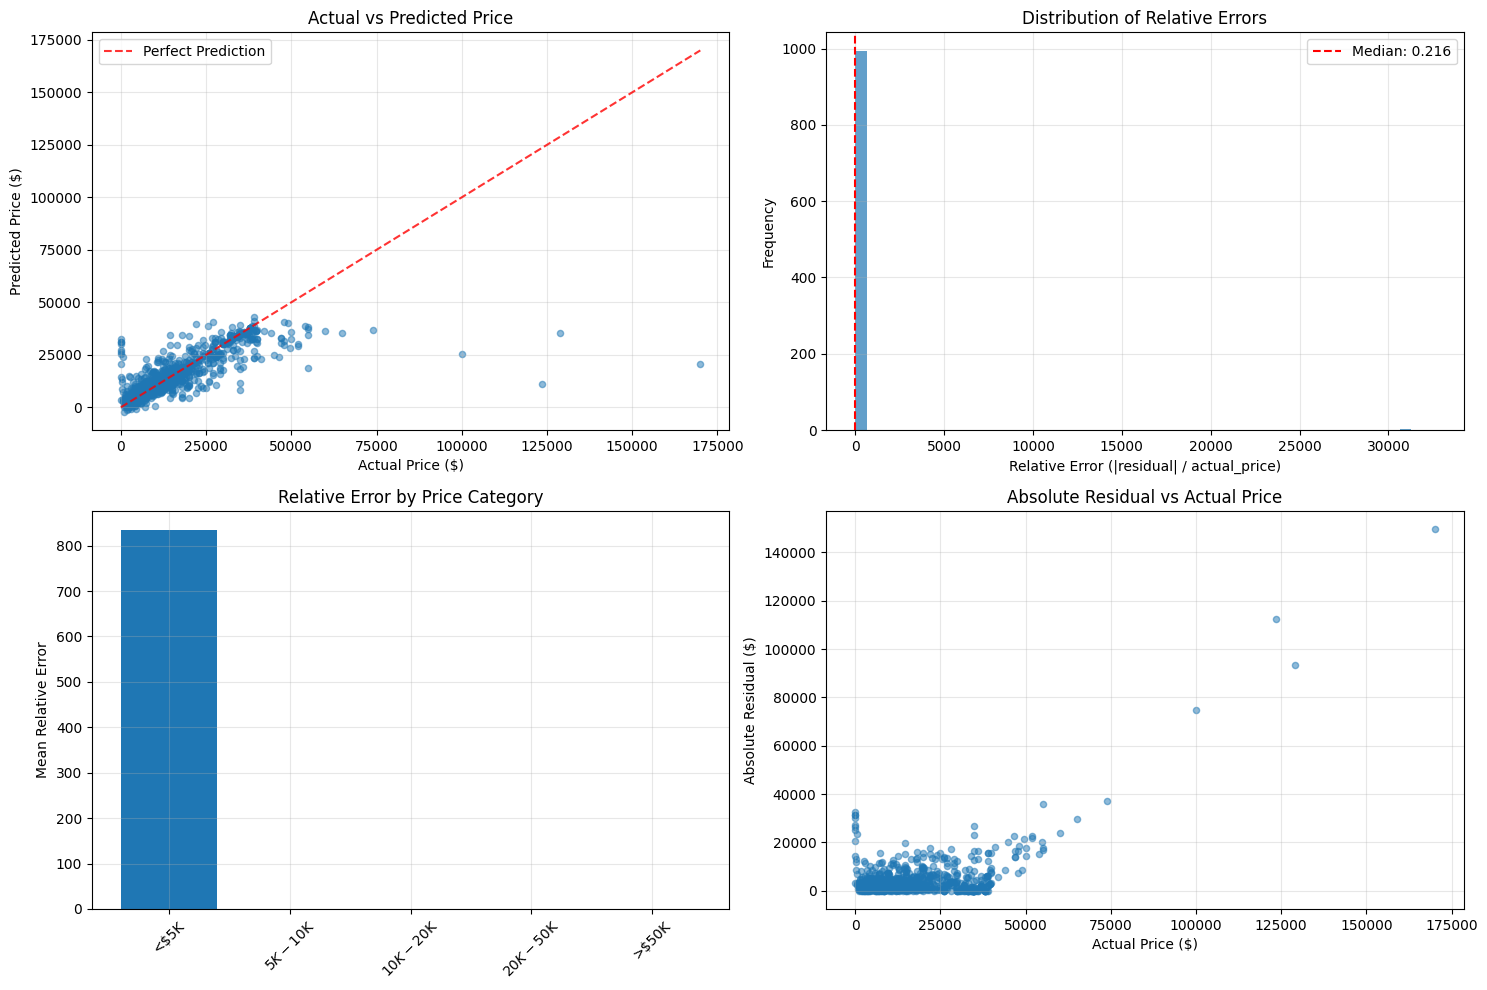

=== 予測精度の統計サマリー ===
RMSE: $9,346.84
MAE: $4,135.69
MAPE: 199.582 (19958.2%)
中央値相対誤差: 0.216 (21.6%)
相対誤差の標準偏差: 2384.508


In [21]:
# 外れ値と予測精度の関係分析
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# 実際価格 vs 予測価格の散布図
ax = axes[0, 0]
ax.scatter(
    val_df_analysis["price"], val_df_analysis["predicted_price"], alpha=0.5, s=20
)
# 完璧な予測ライン
max_price = max(
    val_df_analysis["price"].max(), val_df_analysis["predicted_price"].max()
)
ax.plot([0, max_price], [0, max_price], "r--", alpha=0.8, label="Perfect Prediction")
ax.set_xlabel("Actual Price ($)")
ax.set_ylabel("Predicted Price ($)")
ax.set_title("Actual vs Predicted Price")
ax.legend()
ax.grid(True, alpha=0.3)

# 相対誤差の分布
ax = axes[0, 1]
ax.hist(val_df_analysis["relative_error"], bins=50, alpha=0.7)
ax.axvline(
    x=val_df_analysis["relative_error"].median(),
    color="red",
    linestyle="--",
    label=f"Median: {val_df_analysis['relative_error'].median():.3f}",
)
ax.set_xlabel("Relative Error (|residual| / actual_price)")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Relative Errors")
ax.legend()
ax.grid(True, alpha=0.3)

# 価格帯別の相対誤差
ax = axes[1, 0]
price_bins = pd.cut(
    val_df_analysis["price"],
    bins=[0, 5000, 10000, 20000, 50000, float("inf")],
    labels=["<$5K", "$5K-$10K", "$10K-$20K", "$20K-$50K", ">$50K"],
)
val_df_analysis["price_category"] = price_bins
rel_error_by_price = val_df_analysis.groupby("price_category")["relative_error"].mean()
ax.bar(range(len(rel_error_by_price)), rel_error_by_price.values)
ax.set_xticks(range(len(rel_error_by_price)))
ax.set_xticklabels(rel_error_by_price.index, rotation=45)
ax.set_ylabel("Mean Relative Error")
ax.set_title("Relative Error by Price Category")
ax.grid(True, alpha=0.3)

# 残差の絶対値 vs 実際価格
ax = axes[1, 1]
ax.scatter(val_df_analysis["price"], val_df_analysis["abs_residual"], alpha=0.5, s=20)
ax.set_xlabel("Actual Price ($)")
ax.set_ylabel("Absolute Residual ($)")
ax.set_title("Absolute Residual vs Actual Price")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 予測精度の統計サマリー
print("=== 予測精度の統計サマリー ===")
print(
    f"RMSE: ${rmse(val_df_analysis['price'], val_df_analysis['predicted_price']):,.2f}"
)
print(f"MAE: ${val_df_analysis['abs_residual'].mean():,.2f}")
print(
    f"MAPE: {val_df_analysis['relative_error'].mean():.3f} ({val_df_analysis['relative_error'].mean() * 100:.1f}%)"
)
print(
    f"中央値相対誤差: {val_df_analysis['relative_error'].median():.3f} ({val_df_analysis['relative_error'].median() * 100:.1f}%)"
)
print(f"相対誤差の標準偏差: {val_df_analysis['relative_error'].std():.3f}")